In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Yu Mincho'
from IPython.core.display import display
%matplotlib inline

# データの保存場所を指定。
# この場合は、C:/sample/linear_regression/を読み書きする。
WORK_DIR = './linear_regression/'
DATA_DIR = './linear_regression/data/'

# 2.2.1で作ったデータを読み込む
data_for_analysis_loaded = pd.read_pickle(
    f'{DATA_DIR}data_for_analysis_fin.pickle'
)

In [2]:
independent_variables_names = [
    'market_beta', '企業規模', '簿価時価比率', '財務レバレッジ',
    '赤字ダミー', '25日移動平均乖離率', 'PER'
]
columns_to_use = [
    '業種', '翌日収益率', '翌日超過収益率', '収益率', '市場収益率'
] + independent_variables_names

data_for_analysis=data_for_analysis_loaded.assign(
    # 超過収益率を1日分ずらして、Y_iを作成
    翌日超過収益率=lambda x: x['超過収益率'].groupby(level=0).shift(-1),
    # 後のシミュレーションで利用するので一緒に作成しておく
    翌日収益率=lambda x: x['収益率'].groupby(level=0).shift(-1)  
)[columns_to_use]

In [3]:
# 証券コードごとに5つずつ表示して、計算結果を確認
data_for_analysis.dropna(
    subset=independent_variables_names
).groupby(level=0).head()

業種     翌日収益率   翌日超過収益率       収益率     市場収益率  market_beta  \
SC   日時                                                                       
1301 2018-07-06  水産・農林  0.013080  0.013079 -0.010074  0.009835     0.789803   
     2018-07-09  水産・農林 -0.021536 -0.021537  0.013080  0.012250     0.795722   
     2018-07-10  水産・農林 -0.007337 -0.007338 -0.021536  0.002491     0.791096   
     2018-07-11  水産・農林  0.005902  0.005900 -0.007337 -0.008007     0.787078   
     2018-07-12  水産・農林  0.017655  0.017654  0.005902  0.005079     0.787033   
...                ...       ...       ...       ...       ...          ...   
9997 2018-07-06     小売  0.012620  0.012619  0.036957  0.009835     1.406999   
     2018-07-09     小売  0.000000 -0.000002  0.012620  0.012250     1.413808   
     2018-07-10     小売 -0.002933 -0.002934  0.000000  0.002491     1.414583   
     2018-07-11     小売  0.013967  0.013965 -0.002933 -0.008007     1.414332   
     2018-07-12     小売 -0.007249 -0.007250  0.013967  0.005079     1.415856   

                     企業規模    簿価時価比率   財務レバレッジ  赤字ダミー  25日移動平均乖離率       PER  
SC   日時                                                                     
1301 2018-07-06  0.129513  0.186188  0.603951    0.0   -0.189641  0.609249  
     2018-07-09  0.128330  0.186482  0.603710    0.0   -0.254963  0.607403  
     2018-07-10  0.116521  0.211655  0.624104    0.0   -0.450865  0.637237  
     2018-07-11  0.115988  0.209998  0.623172    0.0   -0.428985  0.636298  
     2018-07-12  0.117670  0.205801  0.618506    0.0   -0.385012  0.631460  
...                   ...       ...       ...    ...         ...       ...  
9997 2018-07-06  0.854253  0.090595  0.035068    0.0    0.028584  0.433588  
     2018-07-09  0.853705  0.091853  0.036996    0.0   -0.008108  0.432696  
     2018-07-10  0.854535  0.092928  0.037308    0.0    0.004872  0.436098  
     2018-07-11  0.857097  0.086425  0.032096    0.0    0.078626  0.430033  
     2018-07-12  0.863873  0.073747  0.021346    0.0    0.210931  0.415840  

[17765 rows x 12 columns]

In [4]:
exclude_fin = data_for_analysis[
    data_for_analysis['業種'].apply(
        lambda x: x not in ['銀行', '証券・先物', '保険', 'その他金融']
    )
]

In [6]:
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2018,7,6), level=1)  # 2016年7月6日のデータを取得
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                翌日超過収益率   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     39.22
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           8.53e-53
Time:                        23:23:47   Log-Likelihood:                 6694.4
No. Observations:                2725   AIC:                        -1.337e+04
Df Residuals:                    2717   BIC:                        -1.333e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0007      0.001     -0.578      0.563      -0.003       0.002
market_beta     0.0137      0.001     12.183      0.000       0.012       0.016
企業規模           -0.0012      0.000     -2.773      0.006      -0.002      -0.000
簿価時価比率         -0.0010      0.001     -1.031      0.303      -0.003       0.001
財務レバレッジ        -0.0027      0.001     -2.584      0.010      -0.005      -0.001
赤字ダミー           0.0004      0.002      0.274      0.784      -0.003       0.004
25日移動平均乖離率     -0.0008      0.001     -1.110      0.267      -0.002       0.001
PER             0.0002      0.001      0.443      0.658      -0.001       0.001
==============================================================================
Omnibus:                      969.181   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16821.372
Skew:                           1.224   Prob(JB):                         0.00
Kurtosis:                      14.923   Cond. No.                         6.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2019,7,5), level=1)  
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                翌日超過収益率   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     32.58
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           4.94e-44
Time:                        23:24:29   Log-Likelihood:                 8585.4
No. Observations:                3270   AIC:                        -1.715e+04
Df Residuals:                    3262   BIC:                        -1.711e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0035      0.001     -4.440      0.000      -0.005      -0.002
market_beta    -0.0022      0.001     -3.126      0.002      -0.004      -0.001
企業規模           -0.0041      0.000    -12.193      0.000      -0.005      -0.003
簿価時価比率         -0.0014      0.001     -1.951      0.051      -0.003    6.66e-06
財務レバレッジ         0.0006      0.001      0.800      0.424      -0.001       0.002
赤字ダミー           0.0013      0.001      1.276      0.202      -0.001       0.003
25日移動平均乖離率     -0.0015      0.000     -3.775      0.000      -0.002      -0.001
PER             0.0012      0.000      2.974      0.003       0.000       0.002
==============================================================================
Omnibus:                     1436.519   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40486.886
Skew:                           1.491   Prob(JB):                         0.00
Kurtosis:                      19.978   Cond. No.                         5.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
def cross_sectional_regression_overtime(
    data_with_excess_returns,
    endog_name, exog_names
):
    group_by_date = data_with_excess_returns.groupby('日時')
    
    results = []
    for date_point, values in tqdm(group_by_date):
        
        result = cross_sectional_regression(
            values,
            endog_name,
            exog_names
        )
        if result is None:
            continue
        results.append(result)
    
    results = pd.concat(results)
    return results

In [12]:
def cross_sectional_regression(data, endog_name, exog_names):
    data = data.reset_index()
    data = data.dropna(subset=endog_name + exog_names)

    if data.shape[0] < 1:  # 空のDataFrameは無視する
        return None

    end_date = data['日時'].max()

    endog = data[endog_name]

    exog = data[exog_names]
    exog = exog.assign(constant=1)

    model = sm.OLS(endog, exog)

    result = model.fit()
    betas = result.params.rename(end_date)

    result = pd.DataFrame(betas).T

    return result

In [13]:
def calculate_mean_value_of_coefficients(coefficients):
    mean = coefficients.mean().rename('mean')
    std_err = (
        coefficients.std() / np.sqrt(coefficients.shape[0])
    ).rename('std err')
    t_stat = (mean / std_err).rename('t-stat')
    
    result = pd.concat([mean, std_err, t_stat], axis=1)
    
    return result

In [14]:
coefficients_excluding_fin = cross_sectional_regression_overtime(
    exclude_fin, endog_name=['翌日超過収益率'],
    exog_names=independent_variables_names
)

# 結果を出力して確認
display(coefficients_excluding_fin.head())  

,market_beta,企業規模,簿価時価比率,財務レバレッジ,赤字ダミー,25日移動平均乖離率,PER,constant
2018-07-06,0.013730,-0.001189,-0.000962,-0.002692,0.000433,-0.000756,0.000237,-0.000690
2018-07-09,0.003322,-0.001420,0.000508,0.002042,-0.002040,-0.002168,0.001746,-0.001664
2018-07-10,-0.005873,-0.001636,-0.001546,0.000714,-0.004169,0.002028,-0.000297,-0.001344
2018-07-11,0.002127,-0.000938,-0.001989,-0.001742,-0.002161,-0.001177,-0.000093,0.001806
2018-07-12,0.001982,0.003677,0.000726,-0.001932,-0.001696,-0.003516,-0.000635,0.004683


In [15]:
result = calculate_mean_value_of_coefficients(
    coefficients_excluding_fin
)

# 結果を出力して確認
display(result)

,mean,std err,t-stat
market_beta,0.000187,0.000415,0.449709
企業規模,0.000001,0.000121,0.008991
簿価時価比率,0.000057,0.000103,0.553844
財務レバレッジ,-0.000175,0.000094,-1.854942
赤字ダミー,-0.000339,0.000137,-2.472540
25日移動平均乖離率,-0.000725,0.000095,-7.665610
PER,0.000088,0.000039,2.243623
constant,-0.000133,0.000270,-0.494715


In [16]:
result[['mean']].applymap(lambda x: '{:.2%}'.format(x * 250))  # 表2-1を作成

,mean
market_beta,4.67%
企業規模,0.03%
簿価時価比率,1.43%
財務レバレッジ,-4.37%
赤字ダミー,-8.48%
25日移動平均乖離率,-18.12%
PER,2.21%
constant,-3.33%


findfont: Font family ['Yu Mincho'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Yu Mincho'] not found. Falling back to DejaVu Sans.


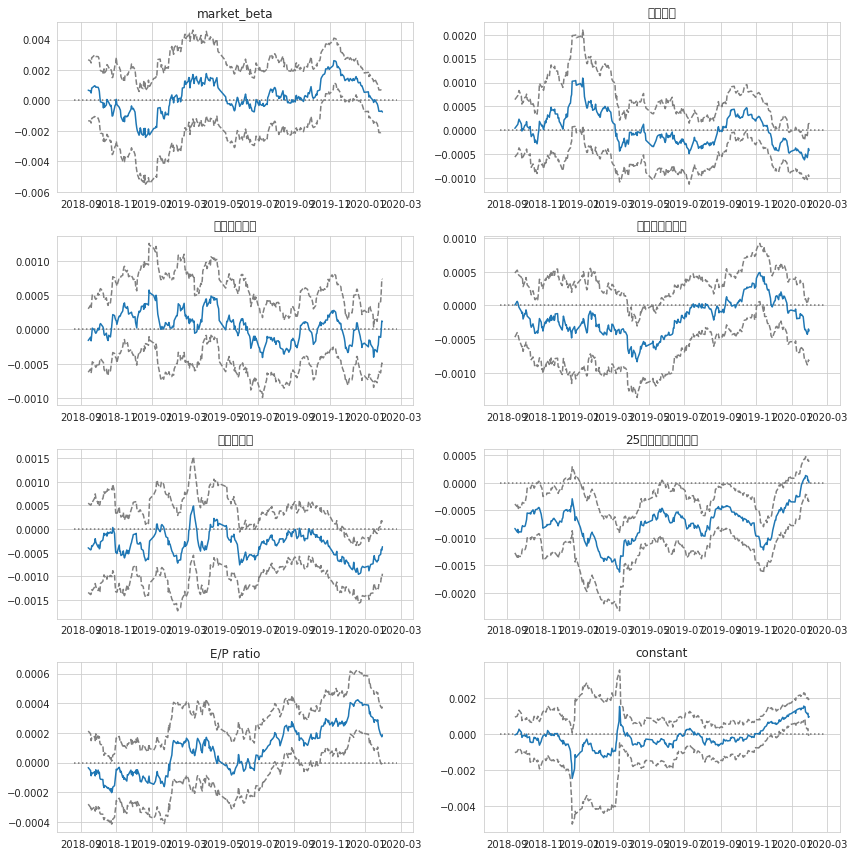

In [17]:
window_size = 50
rolling_coefficients = coefficients_excluding_fin.rolling(
    window_size
).mean()

rolling_std_err = (
    coefficients_excluding_fin.rolling(window_size).std()
    / np.sqrt(window_size)
)

rolling_coefficients.index.rename('日付', inplace=True)

fig, axes=plt.subplots(4, 2, figsize=(12, 12))

for col, ax in zip(rolling_coefficients.columns, axes.flatten()):
    sns.lineplot(data=rolling_coefficients[col], ax=ax)
    sns.lineplot(
        data=rolling_coefficients[col] + 2 * rolling_std_err[col],
        ax=ax,
        color='gray'
    )
    sns.lineplot(
        data=rolling_coefficients[col] - 2 * rolling_std_err[col],
        ax=ax,
        color='gray'
    )
    ax.hlines( # y = 0の破線を引く
        0, *ax.get_xlim(), 
        linestyles=':', alpha=.5
    )    
    for line in ax.get_lines()[1:]:
        line.set_linestyle('--')
    ax.set_title(col if col != 'PER' else 'E/P ratio')

fig.tight_layout() # グラフ同士の間隔を広げる

In [18]:
def create_portfolio_by_one_variable(
    data,
    sort_by,
    q,
    labels=None,
    group_name=None
):
    group_by_date = data.groupby('日時')
    
    if isinstance(q, int) and labels is None:
        labels = range(q)

    values = []
    for date, value in group_by_date:
        if value[sort_by].isnull().all(): # 空のDataFrameは無視する
            continue
            
        value = value.assign(
            quantile=lambda x: pd.qcut(
                x[sort_by], q, labels=labels
            )
        )
        
        if group_name is not None:
            value.rename(columns={'quantile':group_name}, inplace=True)
            
        values.append(value)
    
    return pd.concat(values)

In [19]:
portfolio_by_mv = create_portfolio_by_one_variable(
    data=exclude_fin,
    sort_by='25日移動平均乖離率',
    q=5,
    labels=range(5),
    group_name='MV_quantile'
)

In [20]:
portfolio_by_mv.head()

,,業種,翌日収益率,翌日超過収益率,収益率,市場収益率,market_beta,企業規模,簿価時価比率,財務レバレッジ,赤字ダミー,25日移動平均乖離率,PER,MV_quantile
SC,日時,,,,,,,,,,,,,
1301,2018-02-09,水産・農林,-0.030189,-0.030192,-0.019291,-0.01805,NaN,0.164609,-0.001584,0.503497,0.0,-0.366472,0.279986,1
1332,2018-02-09,水産・農林,0.000000,-0.000003,-0.029685,-0.01805,NaN,0.962178,0.237193,0.654716,0.0,-0.543061,0.749327,1
1333,2018-02-09,水産・農林,-0.019843,-0.019846,-0.025299,-0.01805,NaN,0.993625,-0.032505,0.699774,0.0,1.128227,0.783227,4
1352,2018-02-09,卸売,-0.000934,-0.000937,-0.002588,-0.01805,NaN,-0.689116,-0.019025,0.864594,0.0,0.569575,0.549017,3
1376,2018-02-09,水産・農林,0.015676,0.015673,-0.010343,-0.01805,NaN,-0.324956,0.559051,0.530805,0.0,-0.362127,0.691246,1


In [21]:
portfolio_returns = portfolio_by_mv.groupby(
    ['MV_quantile', '日時']
)['翌日収益率'].mean()

In [22]:
market_return = exclude_fin.groupby(
    '日時'
)['翌日収益率'].mean().rename('単純平均リターン')

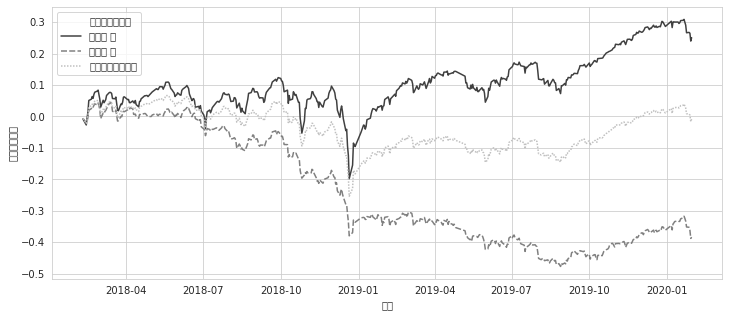

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))

to_plot=portfolio_returns.unstack().T.filter(
    items=[0, 4]
).rename(
    columns={0:'乖離率 低', 4:'乖離率 高'}
).join(
    market_return
).dropna(
    how='all'
).apply(
    lambda column: np.log((column + 1).cumprod())
)
to_plot.columns.rename('ポートフォリオ', inplace=True)

sns.lineplot(
    data=to_plot.stack().reset_index(name='累積リターン'),
    x='日時',
    y='累積リターン',
    hue='ポートフォリオ',
    style='ポートフォリオ',
    palette='gray',
    ax=ax
)

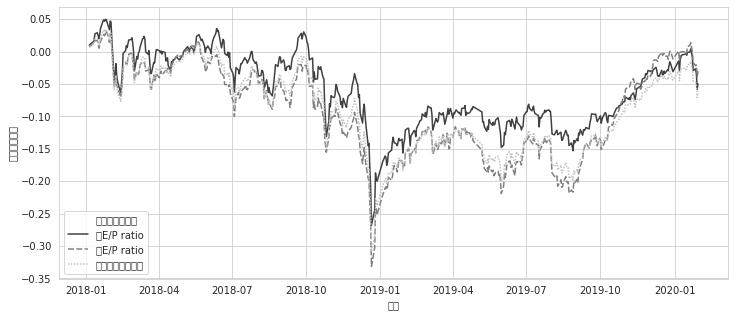

In [24]:
# ポートフォリオの構築
portfolio_by_per = create_portfolio_by_one_variable(
    data=exclude_fin,
    sort_by='PER',
    q=5,
    labels=range(5),
    group_name='PER_quantile'
)

# 累積リターンの計算
portfolio_returns = portfolio_by_per.groupby(
    ['PER_quantile', '日時']
)['翌日収益率'].mean()

to_plot=portfolio_returns.unstack().T.filter(
    items=[0, 4]
).rename(
    columns={0:'低E/P ratio', 4:'高E/P ratio'}
).join(
    market_return
).dropna(
    how='all'
).apply(
    lambda column: np.log((column + 1).cumprod())
)
to_plot.columns.rename('ポートフォリオ', inplace=True)
_, ax=plt.subplots(figsize=(12, 5))
sns.lineplot(
    data=to_plot.stack().reset_index(name='累積リターン'),
    x='日時',
    y='累積リターン',
    hue='ポートフォリオ',
    style='ポートフォリオ',
    palette='gray',
    ax=ax
)

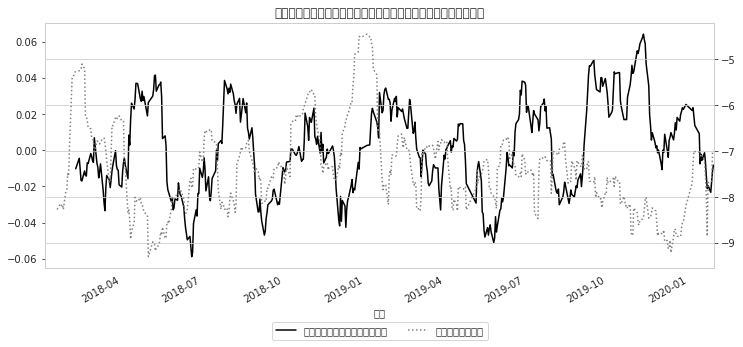

In [25]:
# プロットして比較
fig, ax = plt.subplots(figsize=(12, 5))
handles, labels = [], []
hml = portfolio_returns.loc[4].rolling(25).sum() - portfolio_returns.loc[0].rolling(25).sum()
ax=hml.rename('割安・成長のパフォーマンス差').plot(color='k', ax=ax)
handle, label= ax.get_legend_handles_labels()
handles.extend(handle)
labels.extend(label)

ax=(np.log(market_return.apply(lambda x:x**2).rolling(10).sum()[hml.index])).plot(
    ax=ax, secondary_y=True, linestyle=':', color='gray'
)
handle, label= ax.get_legend_handles_labels()
handles.extend(handle)
labels.extend(label)

ax.set_title('割安・成長ポートフォリオのパフォーマンス差とボラティリティ')
ax.legend(handles, labels, bbox_to_anchor=(.5,-.2), ncol=2, loc='upper center')

In [26]:
def calculate_predicted_values(
    exog,
    shifted_coefficients,
    predicted_value_label='predicted_value'
):
    predicted_returns=[]
    
    group_by_date = exog.groupby(level=1)
    for date, group in tqdm(group_by_date):
        try:
            coefficients_ = shifted_coefficients.xs(date).T

            predicted = np.dot(group.values, coefficients_)
            predicted_returns.append(
                pd.DataFrame(
                    predicted,
                    columns=[predicted_value_label],
                    index=group.index
                )
            )
        except KeyError:
            continue

    predicted_returns = pd.concat(predicted_returns).sort_index()

    return predicted_returns

In [27]:
# ファクターと実測値の準備
X = exclude_fin.assign(constant=1)[coefficients_excluding_fin.columns]

In [28]:
predicted = calculate_predicted_values(
    X,
    coefficients_excluding_fin.shift(),
    '予測リターン'
)

data_with_predicted_values = predicted.join(exclude_fin)

data_with_predicted_values.head()

予測リターン     業種     翌日収益率   翌日超過収益率       収益率     市場収益率  \
SC   日時                                                                    
1301 2018-07-06       NaN  水産・農林  0.013080  0.013079 -0.010074  0.009835   
     2018-07-09  0.008616  水産・農林 -0.021536 -0.021537  0.013080  0.012250   
     2018-07-10  0.004270  水産・農林 -0.007337 -0.007338 -0.021536  0.002491   
     2018-07-11 -0.007095  水産・農林  0.005902  0.005900 -0.007337 -0.008007   
     2018-07-12  0.002277  水産・農林  0.017655  0.017654  0.005902  0.005079   

                 market_beta      企業規模    簿価時価比率   財務レバレッジ  赤字ダミー  25日移動平均乖離率  \
SC   日時                                                                         
1301 2018-07-06     0.789803  0.129513  0.186188  0.603951    0.0   -0.189641   
     2018-07-09     0.795722  0.128330  0.186482  0.603710    0.0   -0.254963   
     2018-07-10     0.791096  0.116521  0.211655  0.624104    0.0   -0.450865   
     2018-07-11     0.787078  0.115988  0.209998  0.623172    0.0   -0.428985   
     2018-07-12     0.787033  0.117670  0.205801  0.618506    0.0   -0.385012   

                      PER  
SC   日時                    
1301 2018-07-06  0.609249  
     2018-07-09  0.607403  
     2018-07-10  0.637237  
     2018-07-11  0.636298  
     2018-07-12  0.631460

In [29]:
portfolio_by_predicted = create_portfolio_by_one_variable(
    data=data_with_predicted_values,
    sort_by='予測リターン',
    q=5,
    labels=range(5),
    group_name='predicted_quantile'
)

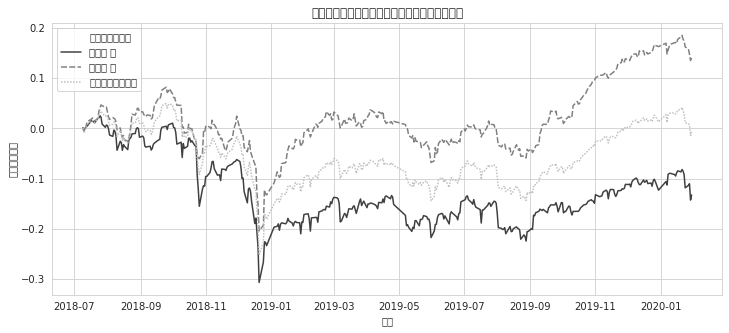

In [30]:
# 累積リターンの計算
portfolio_returns = portfolio_by_predicted.groupby(
    ['predicted_quantile', '日時']
)['翌日収益率'].mean()

# プロットして比較
fig, ax = plt.subplots(figsize=(12, 5))

to_plot=portfolio_returns.unstack().T.filter(
    items=[0, 4]
).rename(
    columns={0:'予測値 低', 4:'予測値 高'}
).join(
    market_return
).dropna(
    how='all'
).apply(
    lambda column: np.log((column + 1).cumprod())
)
to_plot.columns.rename('ポートフォリオ', inplace=True)
sns.lineplot(
    data=to_plot.stack().reset_index(name='累積リターン'),
    x='日時',
    y='累積リターン',
    hue='ポートフォリオ',
    style='ポートフォリオ',
    palette='gray',
    ax=ax
)


ax.set_title('予測値に基づくポートフォリオの累積リターン')
ax.legend(loc='upper left')

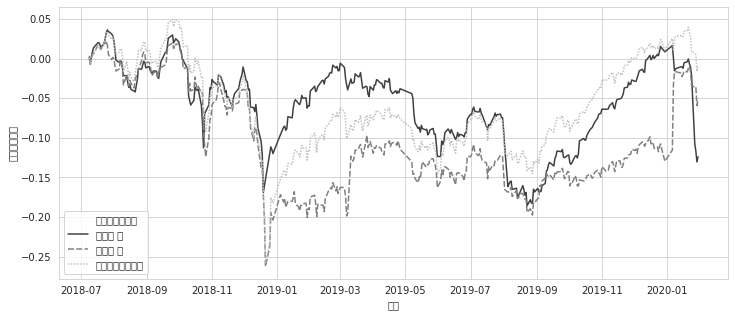

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))

pos_ = portfolio_by_predicted[
    (portfolio_by_predicted['予測リターン'] > 0)
].groupby('日時')['翌日収益率'].mean() + 1

neg_ = portfolio_by_predicted[
    (portfolio_by_predicted['予測リターン']<=0)
].groupby('日時')['翌日収益率'].mean()+1

to_plot = pd.concat(
    [
        np.log(pos_).cumsum().rename('予測値 正'),
        np.log(neg_).cumsum().rename('予測値 負'),
        np.log(market_return[neg_.index] + 1).cumsum()
    ],
    axis=1
)
to_plot.columns.rename('ポートフォリオ', inplace=True)
sns.lineplot(
    data=to_plot.stack().reset_index(name='累積リターン'),
    x='日時',
    y='累積リターン',
    hue='ポートフォリオ',
    style='ポートフォリオ',
    palette='gray',
    ax=ax
)

In [32]:
test_predicted = cross_sectional_regression_overtime(
    data_with_predicted_values,
    endog_name=['翌日超過収益率'],
    exog_names=['予測リターン']
)

calculate_mean_value_of_coefficients(test_predicted)

,mean,std err,t-stat
予測リターン,0.074651,0.038432,1.942426
constant,-0.000661,0.000403,-1.638281
